In [1]:
%%capture
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
import sys
from scipy import signal
import pandas as pd
import tensorflow as tf
from numba import cuda
import numba
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
%run GRUSupportFns.ipynb
import mpld3
mpld3.enable_notebook()


In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Bidirectional, LSTM
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K 
from IPython.display import clear_output
from tensorflow.python.keras.initializers import RandomUniform
# tf.enable_eager_execution()

## Load DataStream and Ground Truth
As no reliable ground truth currently, using Kalman Filter results. Note: Ground truth must currently have the same timesteps as the input.

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

In [3]:
training_files = ['uni1']
testing_files = ['uni', 'data5']

training_dataset = load_datasets(training_files)
testing_dataset = load_datasets(testing_files)

Parsing Data uni1
Freq. of Acceleration 1582.9624444568012
Freq. of Lin. Acceleration 680.3111535212735
Interpolated Samples
Rotated Acceleration
Loaded Ground Truth
Aligned Ground Truth
Finished Dataset uni1

Parsing Data uni
Freq. of Acceleration 1583.554443181799
Freq. of Lin. Acceleration 669.8833983859098
Interpolated Samples
Rotated Acceleration
Loaded Ground Truth
Aligned Ground Truth
Finished Dataset uni

Parsing Data data5
Freq. of Acceleration 190.0300697928473
Freq. of Lin. Acceleration 49.00211454776328
Interpolated Samples
Rotated Acceleration
Loaded Ground Truth
Aligned Ground Truth
Finished Dataset data5



In [4]:
seq_len = 600
batch_size = 512
seq_offset = 50
training_length = 0
for activity in training_dataset:
    training_length += len(activity[0])

batches_per_epoch = int(training_length/batch_size + 1)

In [5]:
%matplotlib notebook
colors = matplotlib.cm.rainbow(np.linspace(0, 1, 10))

plt.figure(figsize=(9.5, 8))
ax=plt.subplot(111)
for i in range(0, len(training_dataset[0][0]), seq_len):
    plt.plot(training_dataset[0][0][i:i+seq_len, 0], training_dataset[0][0][i:i+seq_len, 1], '-', 
             c=colors[int(i/seq_len) % 10])    
    plt.plot(training_dataset[0][1][i:i+seq_len, 0], training_dataset[0][1][i:i+seq_len, 1], '-', 
             c=colors[int(i/seq_len) % 10])

<IPython.core.display.Javascript object>

In [6]:
scaled_training_dataset, scaled_testing_dataset = scale_dataset(training_dataset, testing_dataset)
print(scaled_training_dataset[0][0])
print(scaled_training_dataset[0][1])

[[0.5        0.5        0.49908704 ... 0.497342   0.495079   0.5       ]
 [0.5        0.5        0.49906953 ... 0.497342   0.495079   0.50000042]
 [0.5        0.5        0.49905604 ... 0.497342   0.495079   0.50000042]
 ...
 [0.6659764  0.41639955 0.49957904 ... 0.4976525  0.50171933 0.50000042]
 [0.6659764  0.41639955 0.49955344 ... 0.4976525  0.50171933 0.50000042]
 [0.6659764  0.41639955 0.49952776 ... 0.4976525  0.50171933 0.50000042]]
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 ...
 [0.66549746 0.41487529]
 [0.66549746 0.41487529]
 [0.66549746 0.41487529]]


## Create Validation Data Set

In [7]:
x_train_seqs, y_train_seqs = get_seqs(sequence_length=seq_len, dataset=scaled_training_dataset, offset=seq_offset)
x_test_seqs, y_test_seqs = get_seqs(sequence_length=seq_len, dataset=scaled_testing_dataset, offset=seq_offset)
print(x_train_seqs.shape)
print(x_test_seqs.shape)


val_batch_size = int(0.1*batches_per_epoch*batch_size)
val_generator = batch_generator(batch_size=val_batch_size, x_seqs=x_test_seqs, y_seqs=y_test_seqs)
val_batch_x, val_batch_y = next(val_generator)

validation_data = (val_batch_x, val_batch_y)
print(validation_data[0].shape)

(5126, 600, 11)
(4896, 600, 11)
Batches per Epoch:  1
(4896, 600, 11)


## Start Tensorflow Session 

Batches in the shape (Batch Size, Sequence Length, Feature Vector Length)

Hyper-parameters:
 - Batch Size
 - Sequence Length
 - Number of States in RNN layer
 - GRU or LSTM Layer
 - All forward facing layers, or bidirectional


In [8]:
sess = tf.InteractiveSession()
generator = batch_generator(batch_size=batch_size, x_seqs=x_train_seqs, y_seqs=y_train_seqs)

In [9]:
model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=128, return_sequences=True, input_shape=(None, x_dim,)))
# model.add(GRU(units=1024, return_sequences=True))
model.add(Dense(y_dim, activation='linear'))

In [10]:
# model = Sequential()
# model.add(Bidirectional(GRU(units=128, return_sequences=True), merge_mode='ave',input_shape=(None, x_dim,)))
# model.add(Bidirectional(GRU(units=128, return_sequences=True), merge_mode='ave',input_shape=(None, x_dim,)))
# model.add(Bidirectional(GRU(units=128, return_sequences=True), merge_mode='ave',input_shape=(None, x_dim,)))
# model.add(Dense(y_dim, activation='linear'))         

In [11]:
warmup_steps = 20

### Compile the Model

In [12]:
optimizer = Adam(lr=1e-3)
model.compile(loss=custom_loss, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 128)         53760     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_4 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_5 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
dense (Dense)                (None, None, 2)           258       
Total para

In [13]:
# path_checkpoint = '23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)      
plot_losses = PlotLosses()

callbacks = [callback_early_stopping,
#              callback_checkpoint,
#              callback_tensorboard,
             plot_losses,
             callback_reduce_lr]


In [14]:
%%time
# model.fit(np.expand_dims(scaled_training_data, axis=0), np.expand_dims(scaled_training_labels, axis=0), epochs=10, 
#           batch_size=32, validation_data=validation_data, callbacks=callbacks)
model.fit_generator(generator=generator,
                    epochs=30,
                    steps_per_epoch=batches_per_epoch, #Number of batches per epoch
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
Batches per Epoch:  11
363/502 [====================>.........] - ETA: 9:44 - loss: 70248.9793

KeyboardInterrupt: 

## Evaluate Model on Test Data

In [15]:
for activity in scaled_testing_dataset:
    print("Test Data")
    result = model.evaluate(x=np.expand_dims(activity[0], axis=0),
                            y=np.expand_dims(activity[1], axis=0))
    print("loss (test-set):", result)

Test Data
1/1 [==============================] - 377s 377s/step
loss (test-set): 39068.44921875
Test Data
1/1 [==============================] - 7s 7s/step
loss (test-set): 3332.54638671875


<IPython.core.display.Javascript object>


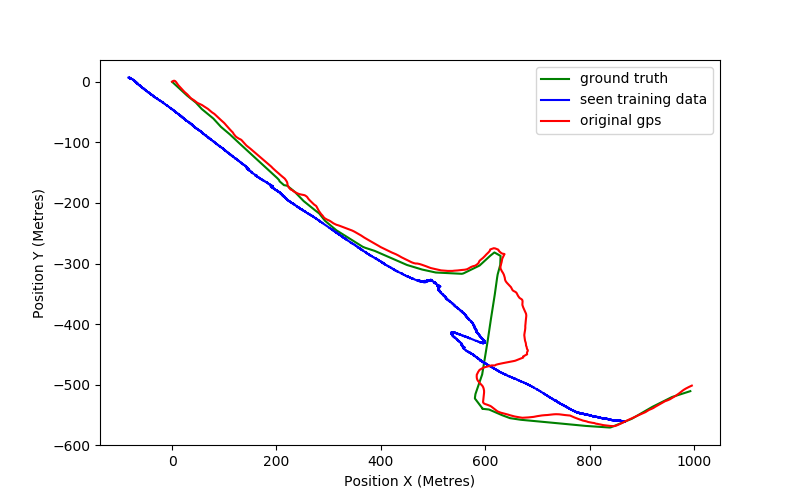

Accuracy of GPS:  12.964319314034105


ValueError: operands could not be broadcast together with shapes (256288,2) (256888,2) 

In [16]:
plot_dataset(training_dataset, seq_len=seq_len)

## Train the Model
 - Choose the maximum amount of epochs
 - How many batches of the data per epoch

In [ ]:
plot_dataset(testing_dataset, seq_len=seq_len)

## Reset Tensorflow Graph

In [ ]:
# tf.reset_default_graph()
# sess.close()